In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams['figure.figsize'] = (10,5)
sns.set(style="whitegrid")

# Output folder for cleaned files & images
from pathlib import Path

out_dir = Path(r"C:\Users\HP\Desktop\vendor_performance_analysis")  # folder only
out_dir.mkdir(parents=True, exist_ok=True)

In [11]:
# CHANGE this path if your CSV is located elsewhere
data_path = Path("C:\\Users\\HP\\Desktop\\vendor_performance_analysis\\Procurement KPI Analysis Dataset.csv")

df = pd.read_csv(data_path)

# Quick peek
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (777, 11)


,PO_ID,Supplier,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Compliance
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,NaN,Yes
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,235.0,Yes
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,41.0,Yes
3,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,Packaging,Delivered,1344,99.85,95.52,112.0,Yes
4,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,Raw Materials,Delivered,1180,64.07,60.53,171.0,No


In [12]:
# Clean column names (strip spaces)
df.columns = df.columns.str.strip()

# Data info and missing values summary
print("Data types & non-null counts:")
display(df.info())
print("\nMissing values per column:")
display(df.isna().sum())


Data types & non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PO_ID             777 non-null    object 
 1   Supplier          777 non-null    object 
 2   Order_Date        777 non-null    object 
 3   Delivery_Date     690 non-null    object 
 4   Item_Category     777 non-null    object 
 5   Order_Status      777 non-null    object 
 6   Quantity          777 non-null    int64  
 7   Unit_Price        777 non-null    float64
 8   Negotiated_Price  777 non-null    float64
 9   Defective_Units   641 non-null    float64
 10  Compliance        777 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 66.9+ KB


None


Missing values per column:


PO_ID                 0
Supplier              0
Order_Date            0
Delivery_Date        87
Item_Category         0
Order_Status          0
Quantity              0
Unit_Price            0
Negotiated_Price      0
Defective_Units     136
Compliance            0
dtype: int64

In [13]:
# 1) Fill Defective_Units NaN with 0 (assume missing means no defect recorded)
if 'Defective_Units' in df.columns:
    df['Defective_Units'] = df['Defective_Units'].fillna(0)

# 2) Parse date columns to datetime (coerce invalid -> NaT)
for col in ['Order_Date', 'Delivery_Date']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# 3) Drop rows missing essential dates (can't compute lead time otherwise)
before = len(df)
df = df.dropna(subset=['Order_Date', 'Delivery_Date'])
print(f"Dropped {before - len(df)} rows due to missing Order_Date or Delivery_Date.")

# 4) Drop cancelled orders if present (they don't represent delivered performance)
if 'Order_Status' in df.columns:
    cancelled_mask = df['Order_Status'].astype(str).str.lower() == 'cancelled'
    cancelled_count = cancelled_mask.sum()
    df = df[~cancelled_mask]
    print(f"Dropped {cancelled_count} cancelled orders.")

# 5) Ensure numeric columns are numeric
numeric_cols = ['Quantity', 'Unit_Price', 'Negotiated_Price', 'Defective_Units']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 6) Drop rows missing essential numeric values (Quantity, Unit_Price, Negotiated_Price)
df = df.dropna(subset=['Quantity', 'Unit_Price', 'Negotiated_Price'])
df.reset_index(drop=True, inplace=True)
print("After cleaning numeric/date essentials, shape is:", df.shape)

Dropped 87 rows due to missing Order_Date or Delivery_Date.
Dropped 55 cancelled orders.
After cleaning numeric/date essentials, shape is: (635, 11)


In [14]:
# Feature engineering - transaction level KPIs
# Lead Time (days)
df['LeadTime'] = (df['Delivery_Date'] - df['Order_Date']).dt.days

# Defect Rate (0..1)
df['DefectRate'] = (df['Defective_Units'] / df['Quantity']).clip(lower=0, upper=1)

# Cost Saving % relative to Unit_Price (positive = savings)
df['CostSavingPct'] = np.where(df['Unit_Price'] == 0, 0,
                              (df['Unit_Price'] - df['Negotiated_Price']) / df['Unit_Price'])
df['CostSavingPct'].replace([np.inf, -np.inf], 0, inplace=True)
df['CostSavingPct'] = df['CostSavingPct'].fillna(0)

# Compliance flag -> 1/0
if 'Compliance' in df.columns:
    df['ComplianceFlag'] = df['Compliance'].astype(str).str.lower().map({'yes':1, 'no':0})
    df['ComplianceFlag'] = df['ComplianceFlag'].fillna(0)
else:
    df['ComplianceFlag'] = 0

# Flag negative lead times (delivery before order) - keep but mark
df['LeadTime_NegativeFlag'] = np.where(df['LeadTime'] < 0, 1, 0)

# Show sample engineered columns
display(df[['PO_ID','Supplier','Order_Date','Delivery_Date','LeadTime','DefectRate','CostSavingPct']].head())


,PO_ID,Supplier,Order_Date,Delivery_Date,LeadTime,DefectRate,CostSavingPct
0,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,10,0.155732,0.050356
1,PO-00003,Gamma_Co,2022-01-26,2022-02-15,20,0.045055,0.034028
2,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,19,0.083333,0.043365
3,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,12,0.144915,0.055252
4,PO-00006,Epsilon_Group,2022-08-17,2022-08-29,12,0.034061,0.081491


In [15]:
# Define OnTimeFlag (workaround)
# If Expected Delivery Date is not present, use Item_Category median lead time as baseline.
if 'Item_Category' in df.columns:
    category_median = df.groupby('Item_Category')['LeadTime'].median().to_dict()
    df['Category_Median_LeadTime'] = df['Item_Category'].map(category_median)
    df['OnTimeFlag'] = np.where(df['LeadTime'] <= df['Category_Median_LeadTime'], 1, 0)
else:
    overall_median = df['LeadTime'].median()
    df['Category_Median_LeadTime'] = overall_median
    df['OnTimeFlag'] = np.where(df['LeadTime'] <= overall_median, 1, 0)

# Quick check
display(df[['Supplier','Item_Category','LeadTime','Category_Median_LeadTime','OnTimeFlag']].head())


,Supplier,Item_Category,LeadTime,Category_Median_LeadTime,OnTimeFlag
0,Delta_Logistics,Office Supplies,10,10.0,1
1,Gamma_Co,MRO,20,12.0,0
2,Beta_Supplies,Packaging,19,11.0,0
3,Delta_Logistics,Raw Materials,12,10.5,0
4,Epsilon_Group,MRO,12,12.0,1


In [16]:
# Descriptive stats and supplier counts 
display(df[['LeadTime','DefectRate','CostSavingPct']].describe().round(3))
print("Unique suppliers:", df['Supplier'].nunique())
display(df['Supplier'].value_counts().head(10))

,LeadTime,DefectRate,CostSavingPct
count,635.000,635.000,635.000
mean,10.709,0.057,0.079
std,5.746,0.051,0.042
min,-5.000,0.000,0.010
25%,6.000,0.020,0.042
50%,11.000,0.040,0.079
75%,16.000,0.097,0.115
max,20.000,0.187,0.150


Unique suppliers: 5


Supplier
Epsilon_Group      139
Delta_Logistics    135
Beta_Supplies      132
Gamma_Co           124
Alpha_Inc          105
Name: count, dtype: int64

In [17]:
# Export cleaned transaction-level CSV (for Power BI) 
clean_csv = out_dir / "clean_vendor_data.csv"
df.to_csv(clean_csv, index=False)
print("Exported cleaned transaction-level CSV to:", clean_csv)

Exported cleaned transaction-level CSV to: C:\Users\HP\Desktop\vendor_performance_analysis\clean_vendor_data.csv


In [18]:
#Vendor-level aggregation 
group_cols = ['Supplier']
vendor_agg = df.groupby(group_cols).agg(
    TotalOrders=('PO_ID', 'nunique'),
    TotalQuantity=('Quantity', 'sum'),
    AvgLeadTime=('LeadTime', 'mean'),
    PctOnTime=('OnTimeFlag', 'mean'),        # fraction 0..1
    AvgDefectRate=('DefectRate', 'mean'),
    AvgCostSavingPct=('CostSavingPct', 'mean'),
    ComplianceRate=('ComplianceFlag', 'mean')
).reset_index()

vendor_agg.fillna(0, inplace=True)
display(vendor_agg.head())


,Supplier,TotalOrders,TotalQuantity,AvgLeadTime,PctOnTime,AvgDefectRate,AvgCostSavingPct,ComplianceRate
0,Alpha_Inc,105,114420,10.361905,0.561905,0.016788,0.080712,0.933333
1,Beta_Supplies,132,153092,11.303030,0.492424,0.083911,0.078924,0.757576
2,Delta_Logistics,135,144951,10.800000,0.518519,0.104619,0.078037,0.607407
3,Epsilon_Group,139,150987,10.920863,0.525180,0.025963,0.078913,0.978417
4,Gamma_Co,124,139235,10.032258,0.580645,0.044969,0.079960,0.846774


In [19]:
# Normalization helpers & VendorScore
# Min-max normalize function (returns neutral 0.5 if no variance)
def min_max(series):
    if series.max() == series.min():
        return pd.Series(0.5, index=series.index)
    return (series - series.min()) / (series.max() - series.min())

# Normalize metrics (0..1). For defect rate lower is better -> invert.
vendor_agg['Norm_OnTime'] = min_max(vendor_agg['PctOnTime'])
vendor_agg['Norm_Defect'] = 1 - min_max(vendor_agg['AvgDefectRate'])
vendor_agg['Norm_Compliance'] = min_max(vendor_agg['ComplianceRate'])
vendor_agg['Norm_CostSaving'] = min_max(vendor_agg['AvgCostSavingPct'])

# Weighted VendorScore - tweak weights if you like
# Suggested weights: OnTime 40%, Defect 30%, Compliance 20%, CostSaving 10%
vendor_agg['VendorScore'] = (
    vendor_agg['Norm_OnTime'] * 0.40 +
    vendor_agg['Norm_Defect'] * 0.30 +
    vendor_agg['Norm_Compliance'] * 0.20 +
    vendor_agg['Norm_CostSaving'] * 0.10
)

# Rank (1 = best)
vendor_agg['Rank'] = vendor_agg['VendorScore'].rank(ascending=False, method='min').astype(int)

# Export vendor summary
vendor_csv = out_dir / "vendor_summary.csv"
vendor_agg.to_csv(vendor_csv, index=False)
print("Exported vendor summary CSV to:", vendor_csv)

# Display top 10
display(vendor_agg.sort_values('VendorScore', ascending=False).head(10))


Exported vendor summary CSV to: C:\Users\HP\Desktop\vendor_performance_analysis\vendor_summary.csv


,Supplier,TotalOrders,TotalQuantity,AvgLeadTime,PctOnTime,AvgDefectRate,AvgCostSavingPct,ComplianceRate,Norm_OnTime,Norm_Defect,Norm_Compliance,Norm_CostSaving,VendorScore,Rank
0,Alpha_Inc,105,114420,10.361905,0.561905,0.016788,0.080712,0.933333,0.787574,1.000000,0.878483,1.000000,0.890726,1
4,Gamma_Co,124,139235,10.032258,0.580645,0.044969,0.079960,0.846774,1.000000,0.679139,0.645176,0.718923,0.804669,2
3,Epsilon_Group,139,150987,10.920863,0.525180,0.025963,0.078913,0.978417,0.371291,0.895534,1.000000,0.327245,0.649901,3
1,Beta_Supplies,132,153092,11.303030,0.492424,0.083911,0.078924,0.757576,0.000000,0.235764,0.404756,0.331557,0.184836,4
2,Delta_Logistics,135,144951,10.800000,0.518519,0.104619,0.078037,0.607407,0.295783,0.000000,0.000000,0.000000,0.118313,5


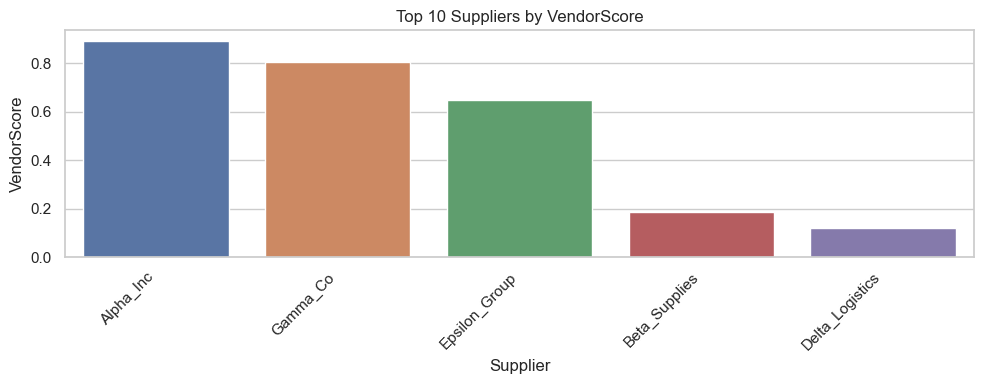

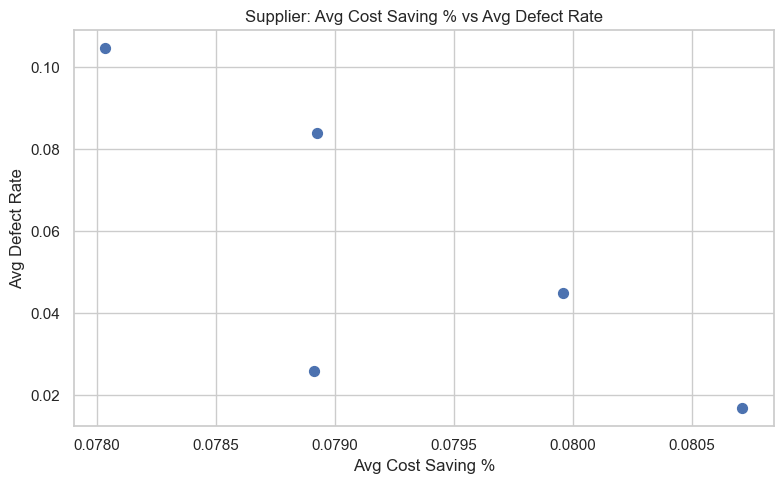

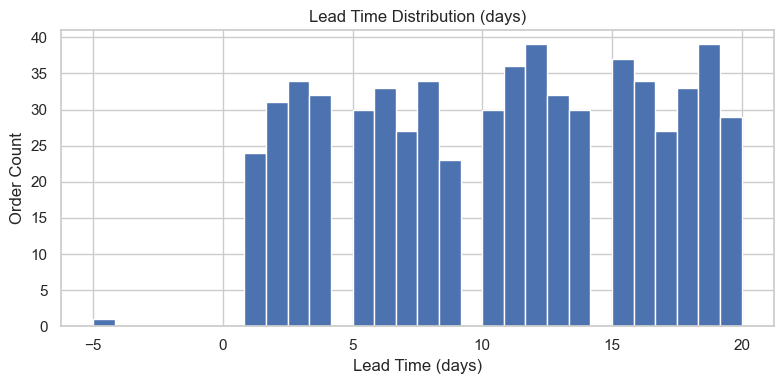

In [20]:
# Plots -Top 10 vendors, scatter, hist 
# Top 10 vendors by VendorScore
top10 = vendor_agg.sort_values('VendorScore', ascending=False).head(10)

plt.figure(figsize=(10,4))
sns.barplot(x='Supplier', y='VendorScore', data=top10)
plt.title("Top 10 Suppliers by VendorScore")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Scatter: AvgCostSavingPct vs AvgDefectRate
plt.figure(figsize=(8,5))
plt.scatter(vendor_agg['AvgCostSavingPct'], vendor_agg['AvgDefectRate'], s=50)
plt.xlabel("Avg Cost Saving %")
plt.ylabel("Avg Defect Rate")
plt.title("Supplier: Avg Cost Saving % vs Avg Defect Rate")
plt.tight_layout()
plt.show()

# LeadTime distribution
plt.figure(figsize=(8,4))
plt.hist(df['LeadTime'].dropna(), bins=30)
plt.title("Lead Time Distribution (days)")
plt.xlabel("Lead Time (days)")
plt.ylabel("Order Count")
plt.tight_layout()
plt.show()


In [21]:
# Save sample chart image(s)
fig1_path = out_dir / "top10_vendors_score.png"
plt.figure(figsize=(10,4))
sns.barplot(x='Supplier', y='VendorScore', data=top10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(fig1_path, dpi=150)
plt.close()
print("Saved sample chart to:", fig1_path)

Saved sample chart to: C:\Users\HP\Desktop\vendor_performance_analysis\top10_vendors_score.png


In [22]:
# Quick summary stats for writing insights
summary_stats = {
    'Avg Lead Time (days)': df['LeadTime'].mean(),
    'Median Lead Time (days)': df['LeadTime'].median(),
    'Overall Avg Defect Rate': df['DefectRate'].mean(),
    'Overall Avg Cost Saving %': df['CostSavingPct'].mean(),
    'Total Vendors': vendor_agg['Supplier'].nunique(),
    'Total Orders (after cleaning)': df['PO_ID'].nunique()
}
print("Quick summary stats (rounded):")
display(pd.Series(summary_stats).round(3))

Quick summary stats (rounded):


Avg Lead Time (days)              10.709
Median Lead Time (days)           11.000
Overall Avg Defect Rate            0.057
Overall Avg Cost Saving %          0.079
Total Vendors                      5.000
Total Orders (after cleaning)    635.000
dtype: float64

In [23]:
# Save cleaned data and vendor summary (already saved) 
# (This cell just confirms files and lists them)
print("Files in output folder:")
for p in out_dir.iterdir():
    print("-", p.name)


Files in output folder:
- clean_vendor_data.csv
- Procurement KPI Analysis Dataset.csv
- top10_vendors_score.png
- vendor_summary.csv
